In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim 
import matplotlib.pyplot as plt

# set a device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


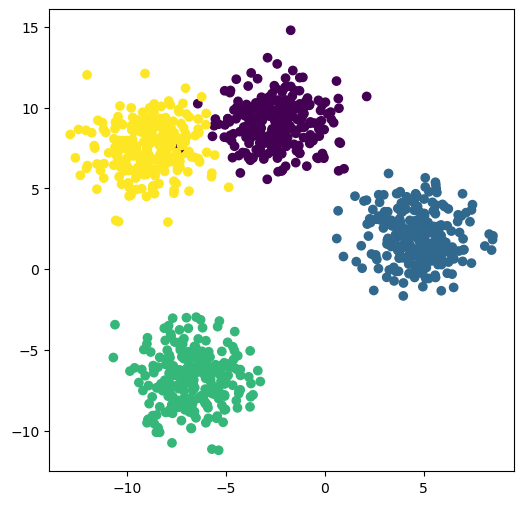

In [2]:
# create multiclass data 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X_blob,y_blob = make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.5, random_state=42)

# turn data into tensors 
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

# split into train/test data sets 
X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,y_blob,test_size=0.2,random_state=42)

# visualize data
plt.figure(figsize=(6,6))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob)

In [3]:
# print X and y shapes 
print(X_blob.shape,y_blob.shape)

torch.Size([1000, 2]) torch.Size([1000])


In [4]:
# build the model 
class BlobClassifier(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features))
        
    def forward(self,x):
        return self.linear_layer_stack(x)
    
model = BlobClassifier(2,4).to(device)
model

BlobClassifier(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
# feed small set of data to test the model 

y_logits = model(X_blob_test[:8].to(device))
y_logits

tensor([[-0.3810,  0.2004,  0.5718, -0.1818],
        [-1.0029,  0.8610,  0.4901, -0.0281],
        [-2.1379,  0.4306,  2.1395,  1.7701],
        [-0.2946,  0.2054,  0.4921, -0.2045],
        [-0.6263,  0.3196,  0.6866, -0.0436],
        [-1.1388,  0.9440,  0.5568,  0.0887],
        [-2.0159,  0.4091,  1.9588,  1.5892],
        [-0.6788,  0.4138,  0.6157, -0.1005]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [6]:
# use softmax to get probabilities 

y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs

tensor([[0.1515, 0.2709, 0.3928, 0.1849],
        [0.0687, 0.4432, 0.3059, 0.1822],
        [0.0074, 0.0960, 0.5302, 0.3664],
        [0.1684, 0.2776, 0.3698, 0.1842],
        [0.1101, 0.2835, 0.4092, 0.1972],
        [0.0559, 0.4487, 0.3046, 0.1908],
        [0.0098, 0.1105, 0.5203, 0.3595],
        [0.1062, 0.3167, 0.3876, 0.1894]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [7]:
# which class to pick, based on the highest prob

y_class = torch.argmax(y_pred_probs,dim=1)
y_class

tensor([2, 1, 2, 2, 2, 1, 2, 2], device='cuda:0')

In [8]:
# create loss fucntion and optimizer 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.1)
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task='multiclass',num_classes=4).to(device)

In [9]:
# train and test the model 

torch.manual_seed(42)

# number of epochs 
epochs = 1000

# put data into target device 
X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# train/test loop 

for epoch in range(epochs):
    ### Training 
    model.train()
    
    # 1. forward pass 
    y_logits = model(X_blob_train)
    y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
    
    # 2. loss and accuracy 
    loss = loss_fn(y_logits,y_blob_train)
    acc = accuracy_fn(y_blob_train,y_pred)
    
    # 3. optimizer zero grad 
    optimizer.zero_grad()
    
    # 4. loss backward 
    loss.backward()
    
    # 5. optimizer step 
    optimizer.step()
    
    ### testing 
    
    model.eval()
    with torch.inference_mode():
        # 1.forward pass
        test_logits = model(X_blob_test)
        test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)
        
        # 2. test loss/accuracy 
        test_loss = loss_fn(test_logits,y_blob_test)
        test_acc = accuracy_fn(test_preds,y_blob_test)
        
    # print
    if epoch % 100 == 0:
        print(f'Epoch:{epoch}|Loss:{loss:.4f} | Acc:{acc:.4f} | Test Loss:{test_loss:.4f} | Test Acc:{test_acc:.4f}')
    

Epoch:0|Loss:1.4719 | Acc:0.2463 | Test Loss:1.2440 | Test Acc:0.2650
Epoch:100|Loss:0.0342 | Acc:0.9937 | Test Loss:0.0255 | Test Acc:0.9950
Epoch:200|Loss:0.0256 | Acc:0.9937 | Test Loss:0.0162 | Test Acc:0.9950
Epoch:300|Loss:0.0235 | Acc:0.9937 | Test Loss:0.0135 | Test Acc:0.9950
Epoch:400|Loss:0.0225 | Acc:0.9937 | Test Loss:0.0122 | Test Acc:0.9950
Epoch:500|Loss:0.0219 | Acc:0.9937 | Test Loss:0.0114 | Test Acc:0.9950
Epoch:600|Loss:0.0215 | Acc:0.9937 | Test Loss:0.0108 | Test Acc:0.9950
Epoch:700|Loss:0.0211 | Acc:0.9937 | Test Loss:0.0104 | Test Acc:0.9950
Epoch:800|Loss:0.0208 | Acc:0.9937 | Test Loss:0.0101 | Test Acc:0.9950
Epoch:900|Loss:0.0206 | Acc:0.9937 | Test Loss:0.0098 | Test Acc:0.9950
